## Tugas 3

# Prediksi Konsumsi Daya Listrik Rumah Tangga Menggunakan LSTM *(Long Short-Term Memory)*

`Hafara Firdausi (05111950010040)`

## 1. Deskripsi
### 1.1 Prasyarat

* Python 3.7.3
* Pandas
* Numpy
* Matplotlib
* TensorFlow
* Scikit-learn
* Jupyter Notebook (optional)

### 1.2 Dataset
Dataset yang digunakan adalah **"Individual Household Electric Power Consumption Dataset"** dari **UCI Machine Learning**, yakni dataset *time series* multivariat berisi **2075259** data yang dikumpulkan di sebuah rumah di Sceaux (7km dari Paris, Prancis) antara Desember 2006 dan November 2010.

Memiliki 9 atribut yang dideskripsikan sebagai berikut:

| Atribut | Deskripsi |
|---|---|
| **date** | Tanggal (dd/mm/yyyy) | 
| **time** | Waktu (hh:mm:ss)| 
| **global_active_power** | Total daya aktif yang dikonsumsi (Kilowatt) |
| **global_reactive_power** | Total daya reaktif yang dikonsumsi (Kilowatt) |
| **voltage** | Tegangan rata-rata (Volt) |
| **global_intensity** | Intensitas Arus Rata-Rata (Ampere) |
| **sub_metering_1** | Energi aktif untuk dapur, berisi mesin pencuci piring, oven, dan *microwave* (Watt-hour energi aktif) |
| **sub_metering_2** | Energi aktif untuk ruang *laundry*, berisi mesin cuci, pengering, kulkas, dan lampu (Watt-hour energi aktif) |
| **sub_metering_3** | Energi aktif untuk kontrol iklim, berisi pemanas air dan AC (Watt-hour energi aktif)|

## 2. Langkah-Langkah yang Dilakukan

In [1]:
## import library yang diperlukan

# basic python libraries 
import os, sys, math

# data handling
import pandas as pd # data processing, CSV file I/O, data manipulation as in SQL
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import numpy as np # linear algebra

# graph plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns 
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# statistics
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

# machine learning
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# deep learning
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import EarlyStopping

### 2.1 Import Dataset

In [2]:
# definisikan dataset path
PATH = os.getcwd()
DATASET_DIR_PATH = PATH + '/dataset/'
DATASET_PATH = DATASET_DIR_PATH + 'household_power_consumption.txt'
PREPARED_DATASET_PATH = DATASET_DIR_PATH + 'household_power_consumption.csv'

In [3]:
# import dataset dalam format .txt
# merge kolom 'Date' and 'Time' menjadi 'datetime'
# convert 'datetime' menjadi data time series dengan membuat'datetime' menjadi index
df = pd.read_csv(DATASET_PATH, sep=';', header=0, low_memory=False, infer_datetime_format=True, 
                parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [4]:
# ambil metadata
print('Jumlah baris :', df.shape[0])
print('Jumlah kolom :', df.shape[1])
print('Atribut :', df.columns.to_list())
print('Time series mulai dari :', df.index.min())
print('Time series berakhir di :', df.index.max())

# lihat data
df.head()

Jumlah baris : 2075259
Jumlah kolom : 7
Atribut : ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
Time series mulai dari : 2006-12-16 17:24:00
Time series berakhir di : 2010-11-26 21:02:00


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [5]:
# lihat data akhir
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0000
2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0000
2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0000
2010-11-26 21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0000
2010-11-26 21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.0000


### 2.2 Prepare dan Preprocess Data

In [6]:
# cek null value
df.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

Null value didapatkan nol semua. Cek data types:

In [7]:
# cek data types
df.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

Ternyata, data types-nya object, sehingga null value tidak terdeteksi.

![](img/1.png)

In [8]:
# pada data ini, null value digambarkan dengan string '?' (tanda tanya), sehingga harus diubah terlebih dahulu menggunakan null value-nya Numpy
# mengganti missing values
df.replace('?', np.nan, inplace=True)
# mengubah semua tipe data menjadi float32
df = df.astype('float32')

In [9]:
# cek tipe data
df.dtypes

Global_active_power      float32
Global_reactive_power    float32
Voltage                  float32
Global_intensity         float32
Sub_metering_1           float32
Sub_metering_2           float32
Sub_metering_3           float32
dtype: object

In [10]:
# cek null value
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Setelah melakukan data preparing dengan mengganti semua string '?' menjadi np.nan dan mengubah tipe datanya menjadi float32, maka didapatkan jumlah missing value sebanyak **25979 x 7**.

In [12]:
# metode yang digunakan untuk mengisi missing value adalah dengan mengisinya menggunakan nilai pada waktu yang sama pada satu hari yang lalu
def fill_missing_value(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [13]:
# mengisi missing value
fill_missing_value(df.values)

In [14]:
# cek null value lagi
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

#### 2.2.1 Export Prepared Data

In [15]:
# export dataset yang telah di prepared dan preprocessed
df.to_csv(PREPARED_DATASET_PATH)

### 2.3 EDA (Exploratory Data Analysis)

#### 2.3.1 Uji Normalitas
Uji Normalitas adalah sebuah uji yang dilakukan dengan tujuan untuk menentukan sebaran data pada sebuah kelompok data atau variabel, apakah sebaran data tersebut terdistribusi normal ataukah tidak.

Dalam hal ini, saya akan menggunakan Tes K-kuadrat **D’Agostino’s K-squared Test** menggunakan SciPy:

* p <= alpha: reject H0, tidak normal
* p> alpha: fail to reject H0, normal

In [16]:
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics = %.3f, p = %.3f' %(stat, p))
alpha = 0.05
if p > alpha:
    print('Terlihat Gaussian (fail to reject H0)')
else:
    print('Tidak terlihat Gaussian (reject H0)')

Statistics = 735736.314, p = 0.000
Tidak terlihat Gaussian (reject H0)


Dari hasil uji tersebut, dapat dilihat bahwa distribusi data ini **tidak normal**.

Kemudian, saya juga menghitung **kurtosis dan skewness** untuk menentukan apakah distribusi data menyimpang dari distribusi normal.

Kurtosis of normal distribution: 4.237163146889262
Skewness of normal distribution: 1.7888684272766113


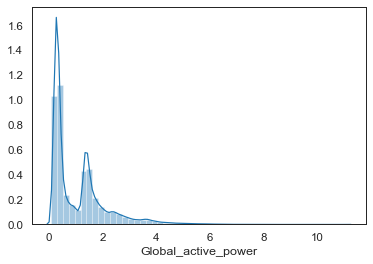

In [14]:
sns.distplot(df.Global_active_power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

* **KURTOSIS**: Distribusi normal memiliki kurtosis mendekati 0. Jika kurtosis lebih besar dari nol, maka distribusi memiliki ekor yang lebih berat. Jika kurtosisnya kurang dari nol, maka distribusinya adalah ekor ringan. Dan Kurtosis data ini lebih besar dari nol.

* **SKEWNESS**: Jika kemiringannya antara -0,5 dan 0,5, datanya cukup simetris. Jika kemiringannya antara -1 dan - 0,5 atau antara 0,5 dan 1, datanya cenderung miring. Jika kemiringan kurang dari -1 atau lebih besar dari 1, data sangat miring. Dan kemiringan kita lebih besar dari 1.

#### 2.3.2 Korelasi antar Fitur
Semakin berkorelasi, maka warnanya semakin terang. Menggunakan metode 'Spearman'.

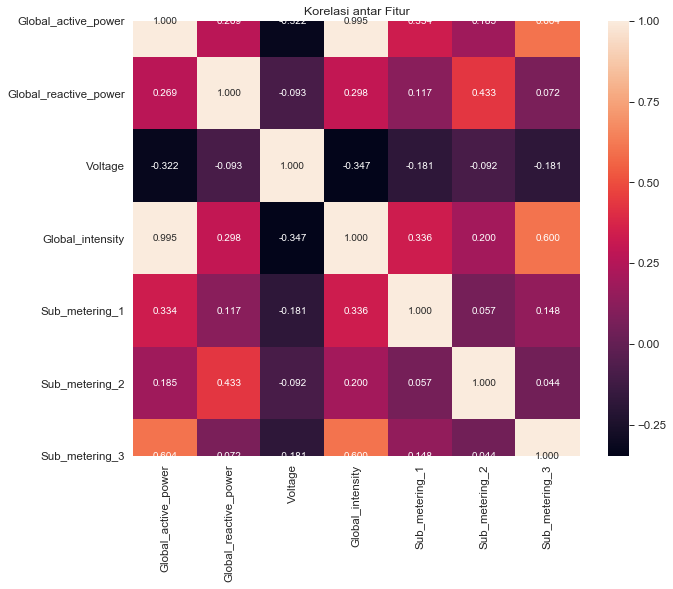

In [17]:
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.3f', ax=ax)
ax.set_title('Korelasi antar Fitur')
plt.show()

Dari dua plot di atas terlihat bahwa **'Global_intensity' dan 'Global_active_power' berkorelasi**, tetapi **'Tegangan' dan 'Global_active_power' kurang berkorelasi**.

#### 2.3.3  Yearly Global Active Power VS Quarterly Global Active Power 

In [18]:
# menyiapkan df for analysis
df.reset_index(level=0, inplace=True)
df['year'] = df['datetime'].apply(lambda x: x.year)
df['quarter'] = df['datetime'].apply(lambda x: x.quarter)
df['month'] = df['datetime'].apply(lambda x: x.month)
df['day'] = df['datetime'].apply(lambda x: x.day)

df_compare = df.loc[:,['datetime','Global_active_power', 'year','quarter','month','day']]
df_compare.sort_values('datetime', inplace=True, ascending=True)
df_compare = df_compare.reset_index(drop=True)
df_compare["weekday"] = df_compare.apply(lambda row: row["datetime"].weekday(),axis=1)
df_compare["weekday"] = (df_compare["weekday"] < 5).astype(int)

df = df.drop(['year','quarter','month','day'], axis=1)
df = df.set_index('datetime')

In [19]:
# ambil metadata
print('Jumlah baris :', df_compare.shape[0])
print('Jumlah kolom :', df_compare.shape[1])
print('Atribut :', df_compare.columns.to_list())
print('Time series mulai dari :', df_compare['datetime'].min())
print('Time series berakhir di :', df_compare['datetime'].max())

# lihat data
df_compare.head()

Jumlah baris : 2075259
Jumlah kolom : 7
Atribut : ['datetime', 'Global_active_power', 'year', 'quarter', 'month', 'day', 'weekday']
Time series mulai dari : 2006-12-16 17:24:00
Time series berakhir di : 2010-11-26 21:02:00


,datetime,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0


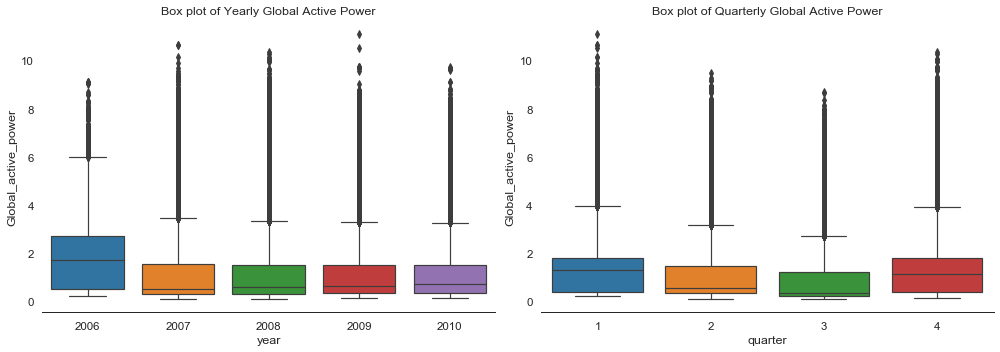

In [20]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=df_compare)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout() 

plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Global_active_power", data=df_compare)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();

**Analisis** : Median pada tahun 2006 jauh lebih tinggi daripada tahun-tahun lainnya. Perlu diingat jika data timeseries ini dimulai pada bulan Desember 2006 (musim dingin), dimana bulan ini merupakan puncak konsumsi listrik. Sedangkan jika di-boxplot berdasarkan musim/kuarter, maka mediannya lebih konsisten: kuarter 1 dan 4 lebih tinggi dibandingkan yang lain karena musim dingin, sedangkan kuarter 3 paling rendah dibandingkan yang lain karena musim panas.

dt.quarter dari Pandas akan membagi kuarter bulan menjadi:
* Month 1 - 3 : quarter 1
* Month 4 - 6 : quarter 2
* Month 7 - 9 : quarter 3
* Month 10 - 12 : quarter 4

Tetapi, 4 Musim di Prancis terjadi pada bulan berikut:
* Spring : 3 - 5 (quarter 1)
* Summer : 6 - 8 (quarter 2)
* Autumn : 9 - 11 (quarter 3)
* Winter : 12 - 2 (quarter 4)

#### 2.3.4 Distribusi Global Active Power

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2075259.0000,1.0894,1.0547,0.0760,0.3080,0.6020,1.5260,11.1220
Global_reactive_power,2075259.0000,0.1237,0.1126,0.0000,0.0480,0.1000,0.1940,1.3900
Voltage,2075259.0000,240.8364,3.2401,223.2000,238.9900,241.0000,242.8700,254.1500
Global_intensity,2075259.0000,4.6184,4.4332,0.2000,1.4000,2.6000,6.4000,48.4000
Sub_metering_1,2075259.0000,1.1185,6.1415,0.0000,0.0000,0.0000,0.0000,88.0000
Sub_metering_2,2075259.0000,1.2911,5.7969,0.0000,0.0000,0.0000,1.0000,80.0000
Sub_metering_3,2075259.0000,6.4486,8.4336,0.0000,0.0000,1.0000,17.0000,31.0000


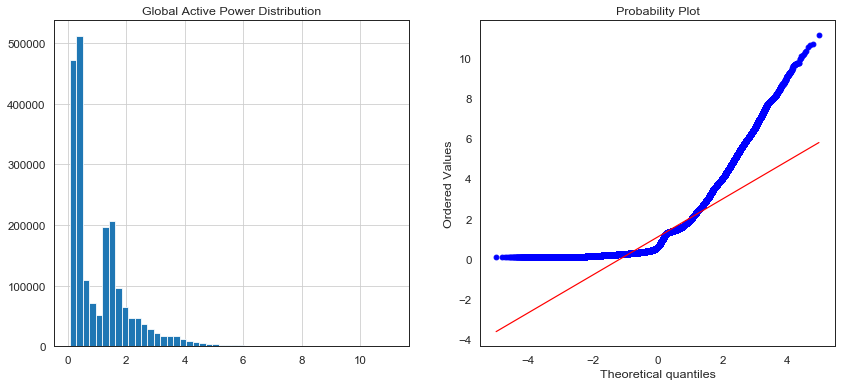

In [21]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'], plot=plt);
df.describe().T

Plot probabilitas juga menunjukkan bahwa data yang digunakan **jauh dari distribusi normal**.

#### 2.3.5 Rata-Rata Global Active Power di-Resample per-Jam, Hari, Minggu, Bulan, Kuarter dan Tahun

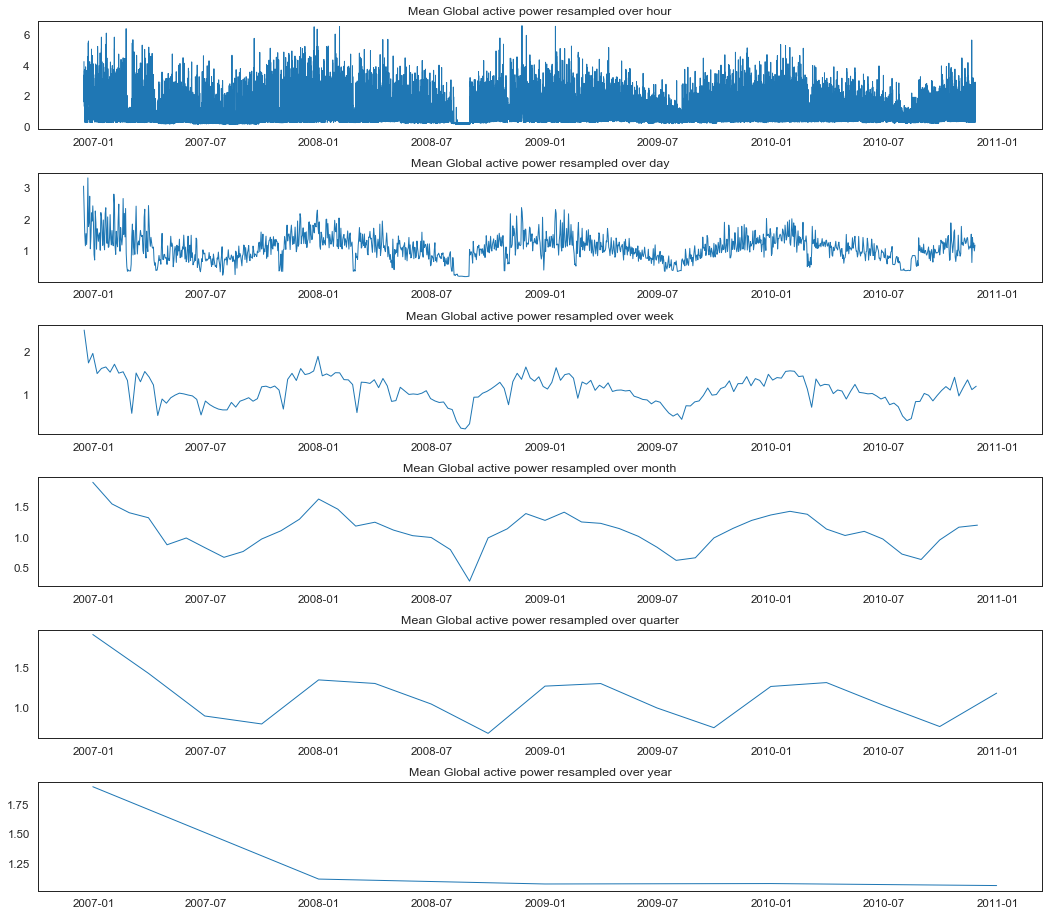

In [22]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)

ax0 = fig.add_subplot(6,1,1)
ax0.plot(df['Global_active_power'].resample('h').mean(),linewidth=1)
ax0.set_title('Mean Global active power resampled over hour')
ax0.tick_params(axis='both', which='major')

ax1 = fig.add_subplot(6,1,2, sharex=ax0)
ax1.plot(df['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(6,1,3, sharex=ax0)
ax2.plot(df['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(6,1,4, sharex=ax0)
ax3.plot(df['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(6,1,5, sharex=ax0)
ax4.plot(df['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(6,1,6, sharex=ax0)
ax5.plot(df['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

#### 2.3.6 Rata-Rata Global Active Power di Group berdasar Tahun, Kuarter, Bulan, dan Hari

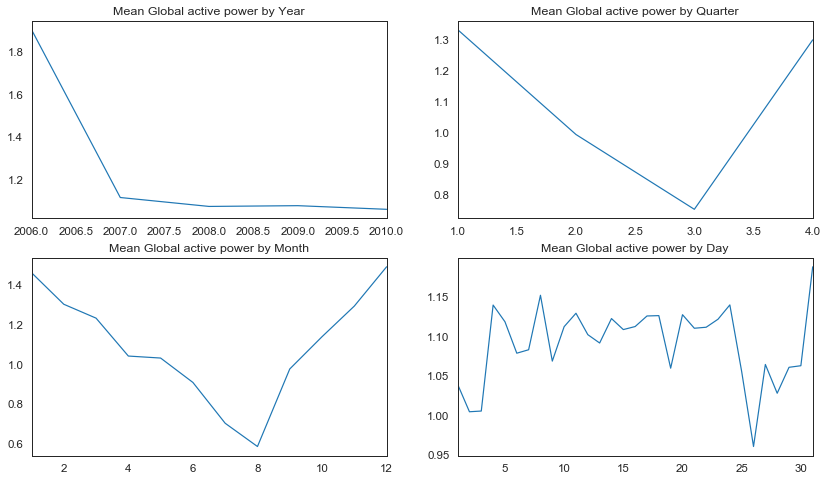

In [23]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df_compare.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df_compare.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df_compare.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df_compare.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

Pada plot berdasar tahun, konsumsi daya rata-rata tertinggi adalah sebelum 2007 dan konsisten setelahnya. Pada plot berdasar kuartal, konsumsi daya rata-rata terendah di kuartal ke-3 (musim panas). Menurut plot berdasar bulan, konsumsi daya rata-rata terendah adalah pada bulan Agustus (musim panas). Pada plot berdasar hari, konsumsi daya rata-rata terendah adalah pada hari ke 26 (tidak tahu mengapa).

#### 2.3.7 Global Active Power Tahunan
Pada tahun 2006 hanya ada bulan Desember, sehingga dihapus saja.

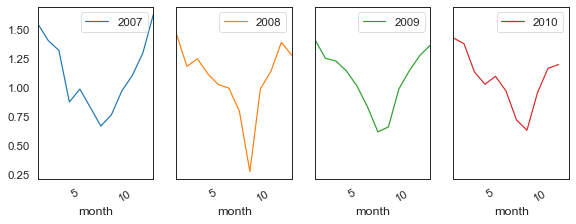

In [24]:
pd.pivot_table(df_compare.loc[df_compare['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

#### 2.3.8 Konsumsi Global Active Power Consumption pada Weekdays vs. Weekends

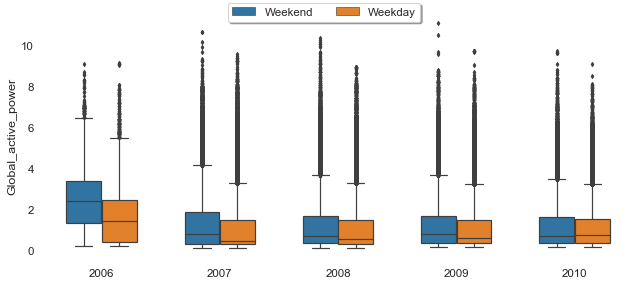

In [25]:
dic = {
    0:'Weekend',
    1:'Weekday'
}
df_compare['Day'] = df_compare.weekday.map(dic)

a = plt.figure(figsize=(9,4)) 
plt1 = sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,
                    data=df_compare)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


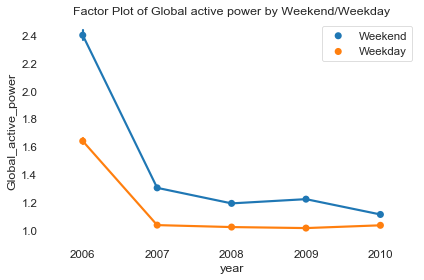

In [26]:
plt1 = sns.factorplot('year','Global_active_power',hue='Day',
                    data=df_compare, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global active power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

### 2.4 LSTM *(Long Short-Term Memory)*
Pada proses LSTM ini, saya hanya menggunakan 1 fitur saja, yaitu **'Global_active_power'**.

In [27]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.2160,0.4180,234.8400,18.4000,0.0000,1.0000,17.0000
2006-12-16 17:25:00,5.3600,0.4360,233.6300,23.0000,0.0000,1.0000,16.0000
2006-12-16 17:26:00,5.3740,0.4980,233.2900,23.0000,0.0000,2.0000,17.0000
2006-12-16 17:27:00,5.3880,0.5020,233.7400,23.0000,0.0000,1.0000,17.0000
2006-12-16 17:28:00,3.6660,0.5280,235.6800,15.8000,0.0000,1.0000,17.0000


Karena mengurangi waktu komputasi, saya melakukan resampling data per-jam.

Untuk versi fullnya, saya melakukan komputasi di google colaboration:
https://colab.research.google.com/drive/14v_wt4rcI0xW5z6YwQqFH_TtdZatNszh

In [28]:
# resample data per-jam 
df_resample = df.resample('h').mean()

In [29]:
# ambil metadata
print('Jumlah baris :', df_resample.shape[0])
print('Jumlah kolom :', df_resample.shape[1])
print('Atribut :', df_resample.columns.to_list())
print('Time series mulai dari :', df_resample.index.min())
print('Time series berakhir di :', df_resample.index.max())

# lihat data
df_resample.head()

Jumlah baris : 34589
Jumlah kolom : 7
Atribut : ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
Time series mulai dari : 2006-12-16 17:00:00
Time series berakhir di : 2010-11-26 21:00:00


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.2229,0.2290,234.6439,18.1000,0.0000,0.5278,16.8611
2006-12-16 18:00:00,3.6322,0.0800,234.5802,15.6000,0.0000,6.7167,16.8667
2006-12-16 19:00:00,3.4002,0.0852,233.2325,14.5033,0.0000,1.4333,16.6833
2006-12-16 20:00:00,3.2686,0.0751,234.0715,13.9167,0.0000,0.0000,16.7833
2006-12-16 21:00:00,3.0565,0.0767,237.1587,13.0467,0.0000,0.4167,17.2167


#### 2.4.1 Normalisasi Data

In [30]:
# ambil nilai Global_active_power dalam bentuk array
values = df_resample.Global_active_power.values 
values

array([4.222889 , 3.6322   , 3.4002333, ..., 1.6593333, 1.1637   ,
       0.9346667], dtype=float32)

In [31]:
# cek dimensi
values.shape

(34589,)

In [32]:
# reshape dimensi
values = np.reshape(values, (-1, 1))
values.shape

(34589, 1)

In [33]:
# normalisasi fitur jadi 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

values

array([[0.6368162 ],
       [0.5450449 ],
       [0.50900584],
       ...,
       [0.23853418],
       [0.16153105],
       [0.12594771]], dtype=float32)

#### 2.4.2 Split Data 
Split data jadi data training (80%) dan data testing (20%).

In [34]:
# determine train and test size
train_size = int(len(values) * 0.80)
test_size = len(values) - train_size
print('Train size: ', train_size)
print('Test size: ', test_size)

Train size:  27671
Test size:  6918


In [35]:
# split data
train, test = values[0:train_size,:], values[train_size:len(values),:]

In [37]:
# cek data train
pd.DataFrame(train).head()

,0
0,0.6368
1,0.5450
2,0.5090
3,0.4885
4,0.4556


In [38]:
# cek data test
pd.DataFrame(test).head()

,0
0,0.0550
1,0.0825
2,0.2039
3,0.3412
4,0.3163


In [39]:
# ubah array menjadi matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [40]:
# reshape jadi X=t and Y=t+1
# 30 jam ke belakang
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [41]:
# cek dimensi X_train
X_train.shape

(27640, 30)

In [42]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.6368,0.5450,0.5090,0.4885,0.4556,0.3226,0.3010,0.2732,0.5011,0.2273,...,0.2388,0.3059,0.4446,0.4975,0.5100,0.5551,0.4326,0.5030,0.4532,0.2166
1,0.5450,0.5090,0.4885,0.4556,0.3226,0.3010,0.2732,0.5011,0.2273,0.2390,...,0.3059,0.4446,0.4975,0.5100,0.5551,0.4326,0.5030,0.4532,0.2166,0.0487
2,0.5090,0.4885,0.4556,0.3226,0.3010,0.2732,0.5011,0.2273,0.2390,0.3250,...,0.4446,0.4975,0.5100,0.5551,0.4326,0.5030,0.4532,0.2166,0.0487,0.0237
3,0.4885,0.4556,0.3226,0.3010,0.2732,0.5011,0.2273,0.2390,0.3250,0.2910,...,0.4975,0.5100,0.5551,0.4326,0.5030,0.4532,0.2166,0.0487,0.0237,0.0294
4,0.4556,0.3226,0.3010,0.2732,0.5011,0.2273,0.2390,0.3250,0.2910,0.1832,...,0.5100,0.5551,0.4326,0.5030,0.4532,0.2166,0.0487,0.0237,0.0294,0.0249


In [43]:
# cek dimensi Y_train
Y_train.shape

(27640,)

In [44]:
pd.DataFrame(Y_train).head()

,0
0,0.0487
1,0.0237
2,0.0294
3,0.0249
4,0.0289


In [45]:
# reshape input menjadi 3D array : [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [46]:
# cek dimensi X_train
X_train.shape

(27640, 1, 30)

#### 2.4.3 Arsitektur Model
* LSTM dengan 100 neurons di layer pertama
* Dropout 20%
* 1 neuron di layer output untuk memprediksi Global_active_power
* Model di fit untuk training epochs = 20 dengan batch size = 70

In [47]:
# membuat model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

W1101 11:08:29.121592 4494579136 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [48]:
# fit jaringan
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Train on 27640 samples, validate on 6887 samples


W1101 11:08:38.824702 4494579136 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
27640/27640 [==============================] - 3s 109us/sample - loss: 0.0126 - val_loss: 0.0072
Epoch 2/20
27640/27640 [==============================] - 2s 71us/sample - loss: 0.0093 - val_loss: 0.0069
Epoch 3/20
27640/27640 [==============================] - 2s 76us/sample - loss: 0.0091 - val_loss: 0.0069
Epoch 4/20
27640/27640 [==============================] - 3s 113us/sample - loss: 0.0090 - val_loss: 0.0070
Epoch 5/20
27640/27640 [==============================] - 2s 83us/sample - loss: 0.0090 - val_loss: 0.0072
Epoch 6/20
27640/27640 [==============================] - 2s 70us/sample - loss: 0.0089 - val_loss: 0.0073
Epoch 7/20
27640/27640 [==============================] - 2s 67us/sample - loss: 0.0088 - val_loss: 0.0073
Epoch 8/20
27640/27640 [==============================] - 2s 66us/sample - loss: 0.0088 - val_loss: 0.0073
Epoch 9/20
27640/27640 [==============================] - 2s 78us/sample - loss: 0.0088 - val_loss: 0.0074
Epoch 10/20
27640/27640 [==========

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               52400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 52,501
Trainable params: 52,501
Non-trainable params: 0
_________________________________________________________________


In [50]:
# bikin prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert prediksi
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.46800867405353697
Train Root Mean Squared Error: 0.6211122146015357
Test Mean Absolute Error: 0.42692339793598466
Test Root Mean Squared Error: 0.5507995415932379


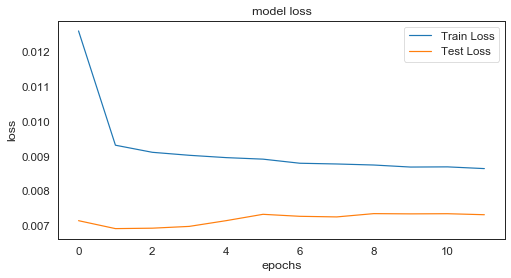

In [51]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

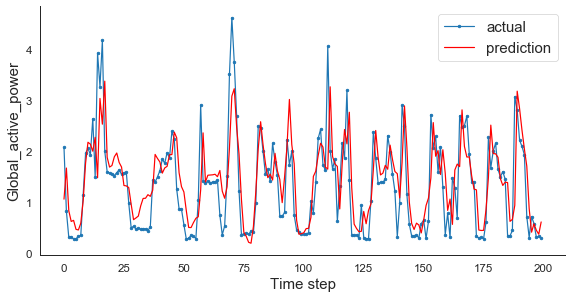

In [52]:
aa = [x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## 3. Referensi
* [T.-Y. Kim and S.-B. Cho, "Predicting Residential Energy Consumption Using CNN-LSTM Neural Networks," Energy, vol. 182, pp. 72-81, 2019.](https://www.sciencedirect.com/science/article/abs/pii/S0360544219311223)
* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/LSTM%20Time%20Series%20Power%20Consumption.ipynb
* [“How to Develop Multi-Step LSTM Time Series Forecasting Models for Power Usage,” *Machine Learning Mastery*, 10-Oct-2018. [Online]. Available: https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/. [Accessed: 12-Oct-2019].](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/)